# Semantic segmentation on IDD Lite Dataset

IDD Lite dataset (<50MB) for semantic segmentaiton into 7 classes

## Imports

In [ ]:
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2, os, random
import seaborn as sns
import pandas as pd
import numpy as np
import shutil 
import datetime
from tensorflow import keras
from tensorflow.keras.layers import SeparableConv2D, ELU, Conv2DTranspose, Conv2D, Activation, Add, Dense, Flatten, concatenate, Input, Reshape, BatchNormalization, ReLU, MaxPooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, ReduceLROnPlateau
from tensorflow.keras.initializers import lecun_normal
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import RMSprop
from keras import applications

Using TensorFlow backend.


In [ ]:
print(tf.__version__)
print(tf.keras.__version__)

2.1.0
2.2.4-tf


## Data cleaning

In [ ]:
def VisSegmentation(image):
    if(isinstance(image, str)):
        image = cv2.imread(image, 0)
    for i in range(len(image)):
        for j in range(len(image[0])):
            if(image[i][j]!=0 or image[i][j]!=255):
                image[i][j] *=42.5
    plt.imshow(image)

In [ ]:
print(os. listdir('idd20k_lite/gtFine'))
print(os. listdir('idd20k_lite/leftImg8bit'))
print(os. listdir('idd20k_lite/gtFine/train'))
print(os. listdir('idd20k_lite/gtFine/train/0'))
print(os. listdir('idd20k_lite/leftImg8bit/train'))
print(os. listdir('idd20k_lite/leftImg8bit/train/0'))

['train', 'val']
['test', 'train', 'val']
['0', '0000002_inst_label.png', '0000002_label.png', '0000097_inst_label.png', '0000097_label.png', '0000192_inst_label.png', '0000192_label.png', '0000215_inst_label.png', '0000215_label.png', '0000247_inst_label.png', '0000247_label.png', '0000280_inst_label.png', '0000280_label.png', '0000342_inst_label.png', '0000342_label.png', '0000367_inst_label.png', '0000367_label.png', '0000444_inst_label.png', '0000444_label.png', '0000446_inst_label.png', '0000446_label.png', '0000450_inst_label.png', '0000450_label.png', '0000502_inst_label.png', '0000502_label.png', '0000540_inst_label.png', '0000540_label.png', '0000654_inst_label.png', '0000654_label.png', '0000704_inst_label.png', '0000704_label.png', '0000792_inst_label.png', '0000792_label.png', '0000822_inst_label.png', '0000822_label.png', '0001033_inst_label.png', '0001033_label.png', '0001055_inst_label.png', '0001055_label.png', '0001149_inst_label.png', '0001149_label.png', '0001196_ins

In [ ]:
dataset_path = 'idd20k_lite/'
img_train = dataset_path + 'leftImg8bit/train/'
seg_train = dataset_path + 'gtFine/train/'
img_val = dataset_path + 'leftImg8bit/val/'
seg_val = dataset_path + 'gtFine/val/'
img_test = dataset_path + 'leftImg8bit/test/'

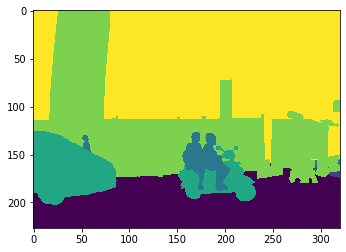

In [ ]:
VisSegmentation(seg_train+'0/024703_label.png')

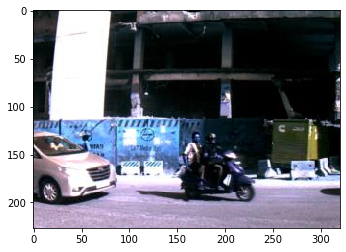

In [ ]:
imgage = cv2.imread(img_train+'0/024703_image.jpg',1)  
plt.imshow(imgage)

In [ ]:
for i in os.listdir(img_train):
    subpath = img_train + i + '/'
    for j in os.listdir(subpath):
        source = subpath + j
        dest = img_train + j
        shutil.copy(source, dest) 

for i in os.listdir(seg_train):
    subpath = seg_train + i + '/'
    for j in os.listdir(subpath):
        source = subpath + j
        dest = seg_train + j
        shutil.copy(source, dest)

for i in os.listdir(img_val):
    subpath = img_val + i + '/'
    for j in os.listdir(subpath):
        source = subpath + j
        dest = img_val + j
        shutil.copy(source, dest) 

for i in os.listdir(img_test):
    subpath = img_test + i + '/'
    for j in os.listdir(subpath):
        source = subpath + j
        dest = img_test + j
        shutil.copy(source, dest) 

for i in os.listdir(seg_val):
    subpath = seg_val + i + '/'
    for j in os.listdir(subpath):
        source = subpath + j
        dest = seg_val + j
        shutil.copy(source, dest)

## Train and test datasets

In [ ]:
train_img = sorted([x for x in os.listdir(img_train) if "." in x])
train_seg = sorted([x for x in os.listdir(seg_train) if "." in x])
val_img = sorted([x for x in os.listdir(img_val) if "." in x])
val_seg = sorted([x for x in os.listdir(seg_val) if "." in x])

In [ ]:
# separating semantic and instance segmentation labels
train_semantic = []
train_instance =[]
for i in range(len(train_seg)):
    if("inst" not in train_seg[i]):
        train_semantic.append(train_seg[i])
    else:
        train_instance.append(train_seg[i])

val_semantic = []
val_instance = []
for i in range(len(val_seg)):
    if("inst" not in val_seg[i]):
        val_semantic.append(val_seg[i])
    else:
        val_instance.append(val_seg[i])

In [ ]:
def getImage(image):

    image = cv2.imread(image, 1)
    image = np.float32(cv2.resize(image, (256, 128))) / 255
    return image

def getSegmentation(image):
    seg_labels = np.zeros((128, 256, 8))
    image = cv2.imread(image, 1)
    image = cv2.resize(image, (256, 128))
    image = image[:, : , 0]
    image[image == 255] = 7
    for i in range(8):
        seg_labels[:, :, i] = (image == i ).astype(int)
    return seg_labels

def image_generator(image_paths, batch_size=32):

    #index = 0;
    while True:
          #np.random.seed(0)
          # Select image_paths (paths/indices) for the batch
          # batch_paths  = np.random.choice(a = image_paths, 
          #                                 size = batch_size, replace=False)
          
          num_samples = len(image_paths)
          for offset in range(0, num_samples, batch_size):
 
            batch_paths = image_paths[offset:offset+batch_size]
            

            batch_input  = []
            batch_output = [] 
            
            # Read in each input, perform preprocessing and get labels
            for input_path in batch_paths:
                image = getImage(input_path)
                seg_path = input_path.replace('leftImg8bit', 'gtFine').replace(\
                  '_image.jpg', '_label.png') 
                seg_mask = getSegmentation(seg_path)
                
                batch_input.append(image)
                batch_output.append(seg_mask)
            # Return a tuple of (input, output) to feed the network
            batch_x = np.array( batch_input )
            batch_y = np.array( batch_output )
            yield(batch_x, batch_y)

In [ ]:
train_gen = image_generator(train_img, batch_size = 32)
val_gen = image_generator(val_img, batch_size=32)

In [ ]:
X_train, Y_train, X_test, Y_test = [], [], [], []

for image, segmentation in zip(train_img, train_semantic):
    X_train.append(getImage(img_train + image))
    Y_train.append(getSegmentation(seg_train + segmentation))
    
for image, segmentation in zip(test_img, test_semantic):
    X_test.append(getImage(img_val + image))
    Y_test.append(getSegmentation(seg_val + segmentation))

In [ ]:
X_train, Y_train, X_test, Y_test = np.array(X_train), np.array(Y_train), np.array(X_test), np.array(Y_test)

In [ ]:
print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

## Model

In [ ]:
def residual_block(inp, f_in, f_out, strides = (1,1)):
    x = inp
    k = (3,3)

    x = SeparableConv2D(f_in, kernel_size=k, strides=(1,1), padding = "same")(x)
    x = BatchNormalization()(x)
    x = ELU()(x)

    x = SeparableConv2D(f_in, kernel_size=k, strides=strides, padding = "same")(x)
    x = BatchNormalization()(x)
    x = ELU()(x)
    
    x = SeparableConv2D(f_out, kernel_size=k, strides=(1,1), padding = "same")(x)
    x = BatchNormalization()(x)
    x = ELU()(x)
    
    inp = SeparableConv2D(f_out, kernel_size=k, strides=strides, padding = "same")(inp)
    inp = BatchNormalization()(inp)
    
    x = Add()([inp, x])
    x = ReLU()(x)

    return x

In [ ]:
def build_model(inp):
    k=(3,3)

    x = Conv2D(16, kernel_size=k, strides = (1,1), padding = "same")(inp)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = MaxPooling2D()(x)
    x = residual_block(x, 16, 32)
    x = MaxPooling2D()(x)
    x = residual_block(x, 32, 64)
    x = MaxPooling2D()(x)
    pool3 = x
    x = residual_block(x, 64, 96)
    x = MaxPooling2D()(x)
    pool4 = x
    x = residual_block(x, 96, 128)
    x = MaxPooling2D()(x)
    pool5 = x
    n = 2048
    nClasses = 8
    
    o = ( Conv2D( n , ( 7 , 7 ) , activation='relu' , padding='same', name="conv6", data_format="channels_last"))(pool5)
    conv7 = ( Conv2D( n , ( 1, 1 ) , activation='relu' , padding='same', name="conv7", data_format="channels_last"))(o)

    conv7_4 = Conv2DTranspose( nClasses , kernel_size=(4,4) , strides=(4,4) , use_bias=False, data_format="channels_last" )(conv7)

    pool411 = ( Conv2D( nClasses , ( 1 , 1 ) , activation='relu' , padding='same', name="pool4_11", data_format="channels_last"))(pool4)
    pool411_2 = (Conv2DTranspose( nClasses , kernel_size=(2,2) , strides=(2,2) , use_bias=False, data_format="channels_last" ))(pool411)

    pool311 = ( Conv2D( nClasses , ( 1 , 1) , activation='relu' , padding='same', name="pool3_11", data_format="channels_last"))(pool3)

    o = Add(name="add")([pool411_2, pool311, conv7_4 ])
    o = Conv2DTranspose( nClasses , kernel_size=(8,8) , strides=(8,8) , use_bias=False, data_format="channels_last" )(o)
    o = (Activation('softmax'))(o)

    return o

inp = Input((128,256,3))
model_f = build_model(inp)
model = Model(inputs= inp, outputs= model_f)
model.compile(optimizer = RMSprop(), loss = "categorical_crossentropy", metrics=["accuracy"])
model.summary()

## Training

In [ ]:
filepath = dataset_path + "model_weights.h5"

checkpoint = ModelCheckpoint(filepath,
                             monitor="val_loss",
                             mode="min",
                             save_best_only = True,
                             verbose=1)

earlystop = EarlyStopping(monitor = 'val_loss', 
                            mode="min",
                            min_delta = 0, 
                            patience = 5,
                            verbose = 1,
                            restore_best_weights = True)

reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.2, patience = 5, verbose = 1, min_delta = 0.0001)


logdir = os.path.join('/logs/')
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

callbacks = [checkpoint, earlystop , reduce_lr,tensorboard_callback]

In [ ]:
history = model.fit(x = X_train, y = Y_train, batch_size = 32, validation_data=(X_test, Y_test), validation_steps=(np.ceil(len(val_img)/32)), callbacks=callbacks, epochs = 50, verbose = 1)

## IOU Score Evaluation & Test Visualization

In [ ]:
def IoU(y_val, y_pred):
    class_iou = []
    n_classes = 7
    
    y_predi = np.argmax(y_pred, axis=3)
    y_truei = np.argmax(y_val, axis=3)
    
    for c in range(n_classes):
        TP = np.sum((y_truei == c) & (y_predi == c))
        FP = np.sum((y_truei != c) & (y_predi == c))
        FN = np.sum((y_truei == c) & (y_predi != c)) 
        IoU = TP / float(TP + FP + FN)
        if(float(TP + FP + FN) == 0):
          IoU=TP/0.001
        class_iou.append(IoU)
    MIoU=sum(class_iou)/n_classes
    return MIoU


In [ ]:
Y_pred = model.predict(X_test)
print('MIoU:',IoU(Y_test, Y_pred))

In [ ]:
plt.imshow(X_test[3])